# Introduction

In [23]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

In [123]:
DATA_DIR = "../data/subway/"

gdf = gpd.read_file(DATA_DIR + "geo_export_1289f38d-6af7-4216-acc1-6dc0cc8a965a.shp")
gdf.head()

,id,name,objectid,rt_symbol,shape_len,url,geometry
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,"LINESTRING (-73.99488 40.68020, -73.99427 40.6..."
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,"LINESTRING (-73.97958 40.65993, -73.97966 40.6..."
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,"LINESTRING (-73.97586 40.57597, -73.97654 40.5..."
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,"LINESTRING (-73.92414 40.75229, -73.92405 40.7..."
4,2000296.0,M,757.0,B,2385.698536,http://web.mta.info/nyct/service/,"LINESTRING (-73.91345 40.75617, -73.90905 40.7..."


In [124]:
gdf['Start_pos'] = gdf.geometry.apply(lambda x: x.coords[0])
gdf['End_pos'] = gdf.geometry.apply(lambda x: x.coords[-1])

make_G_bidi = False
name = "unnamed"

# Create Series of unique nodes and their associated position
s_points = gdf.Start_pos.append(gdf.End_pos).reset_index(drop=True)
s_points = s_points.drop_duplicates()   
#     log('GeoDataFrame has {} elements (linestrings) and {} unique nodes'.format(len(gdf),len(s_points)))

# Add index of start and end node of linestring to geopandas DataFrame
df_points = pd.DataFrame(s_points, columns=['Start_pos'])
df_points['FNODE_'] = df_points.index
gdf = pd.merge(gdf, df_points, on='Start_pos', how='inner')

df_points = pd.DataFrame(s_points, columns=['End_pos'])
df_points['TNODE_'] = df_points.index
gdf = pd.merge(gdf, df_points, on='End_pos', how='inner')

# Bring nodes and their position in form needed for osmnx (give arbitrary osmid (index) despite not osm file)
df_points.columns = ['pos', 'osmid'] 
df_points[['x', 'y']] = df_points['pos'].apply(pd.Series)
df_node_xy = df_points.drop('pos', 1)

# Create Graph Object
G = nx.MultiDiGraph(name=name, crs=gdf.crs)

# Add nodes to graph
for node, data in df_node_xy.T.to_dict().items():
    G.add_node(node, **data)
    
# Add edges to graph
for i, row  in gdf.iterrows():
    dict_row  = row.to_dict()
    if 'geometry' in dict_row: del dict_row['geometry']
    G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)
    
if make_G_bidi:
    gdf.rename(columns={'Start_pos': 'End_pos',
                'End_pos': 'Start_pos',
                'FNODE_': 'TNODE_', 
                'TNODE_': 'FNODE_', }, inplace=True)
    
    # Add edges to graph
    for i, row  in gdf.iterrows():
        dict_row  = row.to_dict()
        if 'geometry' in dict_row: del dict_row['geometry']
        G.add_edge(u_for_edge=dict_row['FNODE_'], v_for_edge=dict_row['TNODE_'], **dict_row)
    
#         G = G.to_undirected() # Some function in osmnx do not work anymore

/var/folders/8g/xwwcgv0168q4xh26jkhwzgjm0000gn/T/ipykernel_39275/512635658.py:24: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_node_xy = df_points.drop('pos', 1)


In [128]:
len(G.edges)

742

In [62]:
H = nx.DiGraph(G)

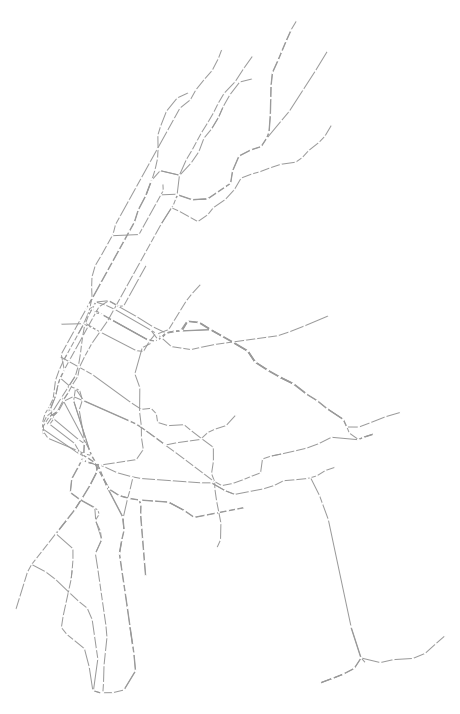

(<Figure size 576x1080 with 1 Axes>, <AxesSubplot:>)

In [129]:
fig, ax = plt.subplots(figsize=(8, 15))

ox.plot_graph(
    G, 
    node_size=5,
    ax=ax
)

In [77]:
ox.get_undirected(G)

KeyError: 'osmid'

In [64]:
nx.info(G)

"MultiDiGraph named 'unnamed' with 847 nodes and 1484 edges"

In [65]:
nx.density(G)

0.00207100013676416

In [66]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [67]:
G.nodes[3]

{'osmid': 3.0, 'x': -73.92414355434533, 'y': 40.752290926571746, 'degree': 4}

In [68]:
len(G.nodes)

847

In [69]:
nx.closeness_centrality(G)

{0: 0.001182033096926714,
 1: 0.0032733224222585926,
 2: 0.001182033096926714,
 3: 0.001182033096926714,
 4: 0.001182033096926714,
 5: 0.001182033096926714,
 6: 0.001182033096926714,
 7: 0.001182033096926714,
 8: 0.001182033096926714,
 9: 0.0028648122032143126,
 10: 0.001182033096926714,
 11: 0.001182033096926714,
 12: 0.001182033096926714,
 13: 0.001182033096926714,
 14: 0.001182033096926714,
 15: 0.0026595744680851063,
 17: 0.001182033096926714,
 18: 0.002364066193853428,
 19: 0.001182033096926714,
 20: 0.001182033096926714,
 21: 0.001182033096926714,
 22: 0.001182033096926714,
 23: 0.001182033096926714,
 24: 0.00511456628477905,
 25: 0.005041847332862761,
 26: 0.0035936523464036307,
 27: 0.0031264775413711587,
 28: 0.003347103819917059,
 29: 0.003155840744493227,
 30: 0.0027845653627881412,
 31: 0.004194471875592264,
 32: 0.003347103819917059,
 33: 0.004194471875592264,
 34: 0.004756410691461084,
 35: 0.002528653080767274,
 36: 0.004008304540219434,
 37: 0.005139274334463974,
 38: 0

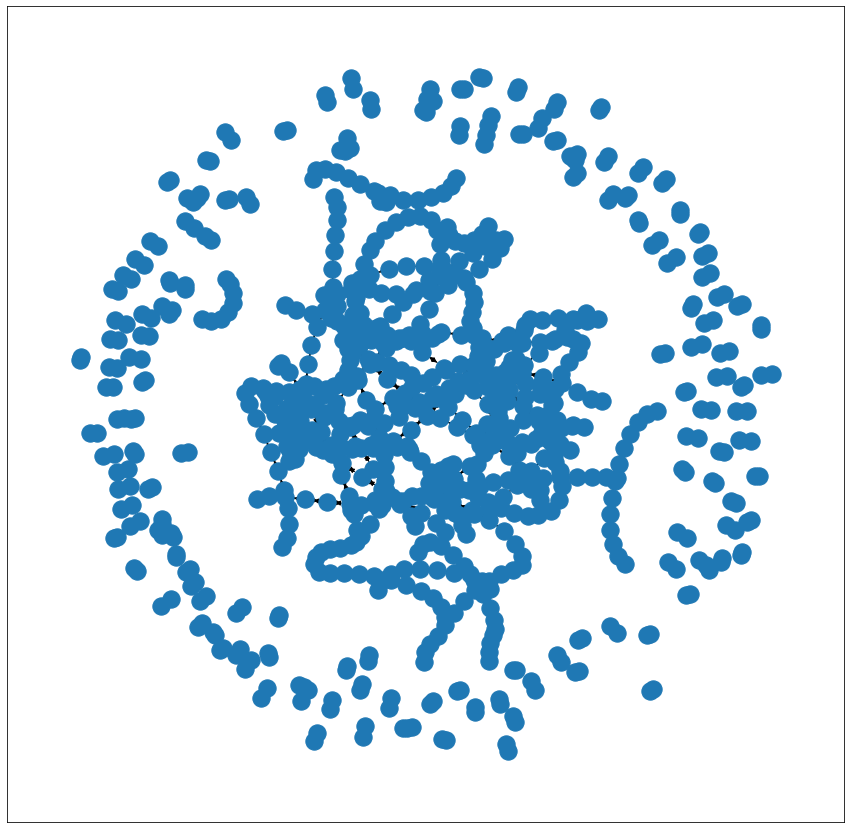

In [70]:
plt.figure(figsize =(15, 15))
nx.draw_networkx(G, with_labels = False)

In [90]:
I = H.to_undirected()

In [94]:
len(I.edges)

685

TypeError: __call__() got an unexpected keyword argument 'keys'

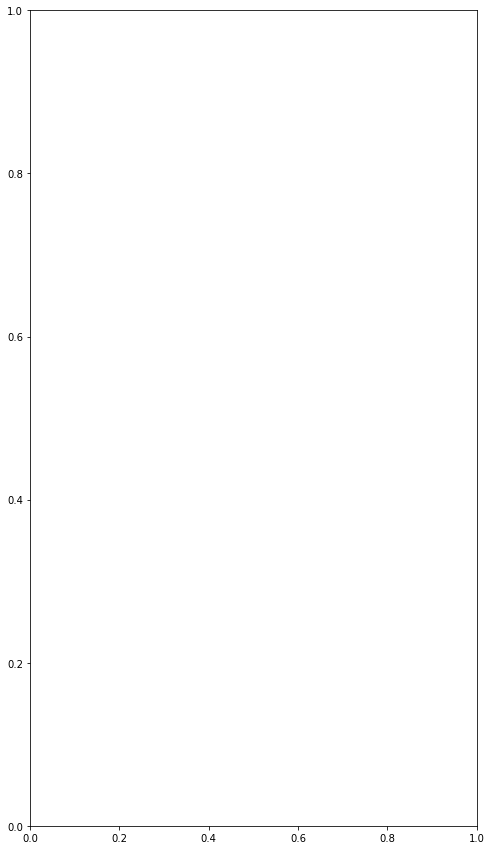

In [96]:
fig, ax = plt.subplots(figsize=(8, 15))

ox.plot_graph(
    I, 
    node_size=5,
    ax=ax
)

In [75]:
edge_centrality = nx.closeness_centrality(nx.line_graph(H))
nx.set_edge_attributes(H, edge_centrality, "edge_centrality")

TypeError: __call__() got an unexpected keyword argument 'keys'

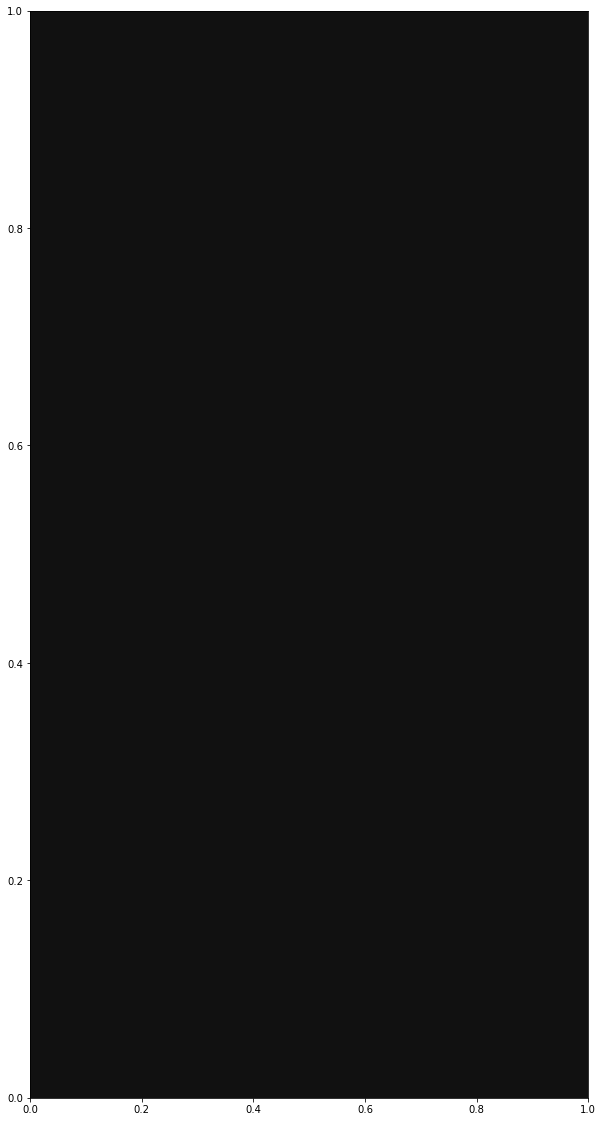

In [76]:
ec = ox.plot.get_edge_colors_by_attr(H, "edge_centrality", cmap="inferno")
fig, ax = ox.plot_graph(H, edge_color=ec, edge_linewidth=2, node_size=0, figsize=(10,20))

In [38]:
ox.get_digraph(G)

KeyError: 'length'

In [110]:
bc = nx.betweenness_centrality(H)
max_node, max_bc = max(bc.items(), key=lambda x: x[1])
max_node, max_bc

(96, 0.0074279239582021915)

In [111]:
bc

{0: 0.0,
 1: 2.238169177612713e-05,
 2: 0.0,
 3: 0.0,
 4: 0.0,
 5: 0.0,
 6: 0.0,
 7: 0.0,
 8: 0.0,
 9: 7.833592121644495e-05,
 10: 0.0,
 11: 0.0,
 12: 0.0,
 13: 0.0,
 14: 0.0,
 15: 5.595422944031782e-06,
 17: 0.0,
 18: 2.797711472015891e-06,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0006266873697315596,
 25: 0.000618294235315512,
 26: 0.0002853665701456209,
 27: 0.00021262607187320774,
 28: 0.0002182214948172395,
 29: 0.0,
 30: 0.0002182214948172395,
 31: 0.0005539468714591464,
 32: 0.000386084183138193,
 33: 0.0005539468714591464,
 34: 0.0005819239861793054,
 35: 3.357253766419069e-05,
 36: 0.00033572537664190694,
 37: 0.0006294850812035755,
 38: 0.0005847216976513212,
 39: 0.00036370249136206587,
 40: 0.00011190845888063565,
 41: 0.0003692979143060976,
 42: 6.15496523843496e-05,
 43: 0.0005707331402912418,
 44: 0.0002517940324814302,
 45: 0.00033572537664190694,
 46: 0.0003133436848657798,
 47: 0.0005875194091233372,
 48: 0.0005035880649628604,
 49: 0.00058751940912333

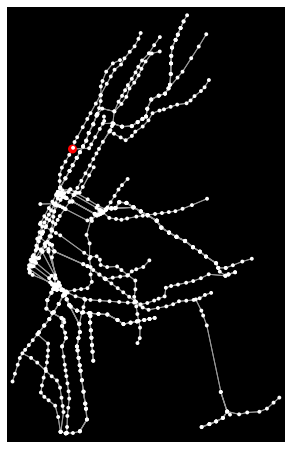

In [47]:
nc = ["r" if node == max_node else "w" for node in G.nodes]
ns = [80 if node == max_node else 15 for node in G.nodes]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2, bgcolor="k")

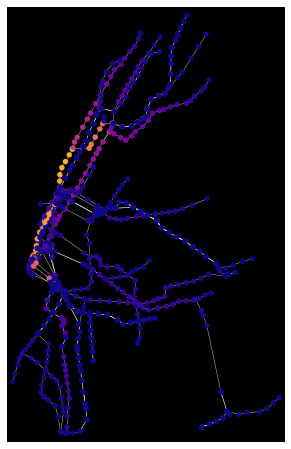

In [51]:
nx.set_node_attributes(G, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
)

In [55]:
nx.is_strongly_connected(G)

False

In [56]:
nx.number_connected_components(G)

NetworkXNotImplemented: not implemented for directed type

# Subway lines through OSMnx

/Users/Lars/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/Lars/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/Lars/opt/anaconda3/envs/OSMNX/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


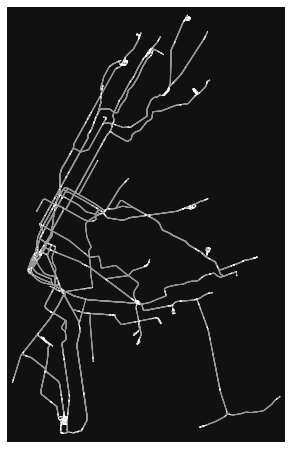

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [85]:
NY = ox.graph_from_place(
    "New York, NY",
    custom_filter='["railway"~"subway"]'
)
ox.plot_graph(
    NY, 
    node_size=1,
)

In [136]:
G_u = G.to_undirected()

In [138]:
reach = {i: nx.algorithms.centrality.reaching.local_reaching_centrality(G_u, v=i) for i in G_u.nodes}
len(reach)

847

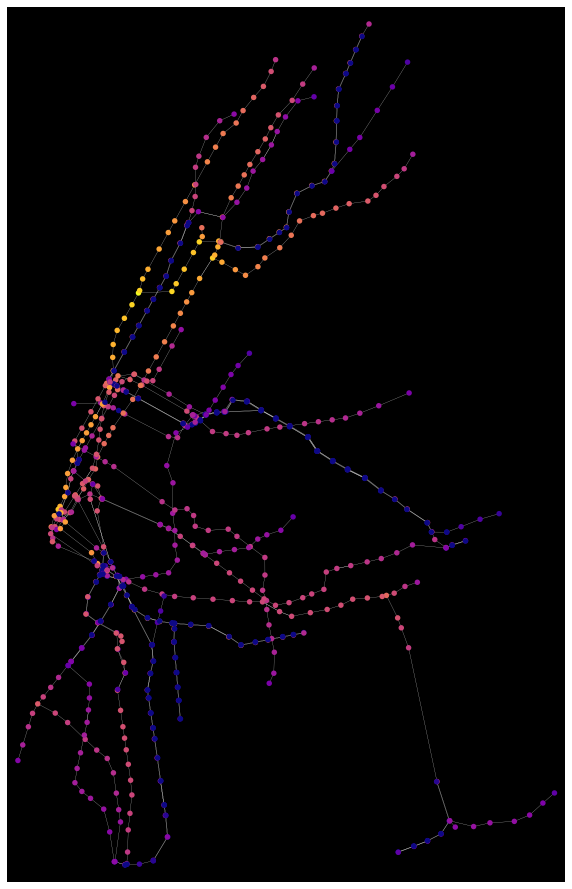

In [142]:
reach = {i: nx.algorithms.centrality.reaching.local_reaching_centrality(G_u, v=i) for i in G_u.nodes}
len(reach)

nx.set_node_attributes(G_u, reach, "reach")
nc = ox.plot.get_node_colors_by_attr(G_u, "reach", cmap="plasma")
fig, ax = ox.plot_graph(
    G_u,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
    figsize=(10, 20)
)

In [147]:
H = nx.to_undirected(H)

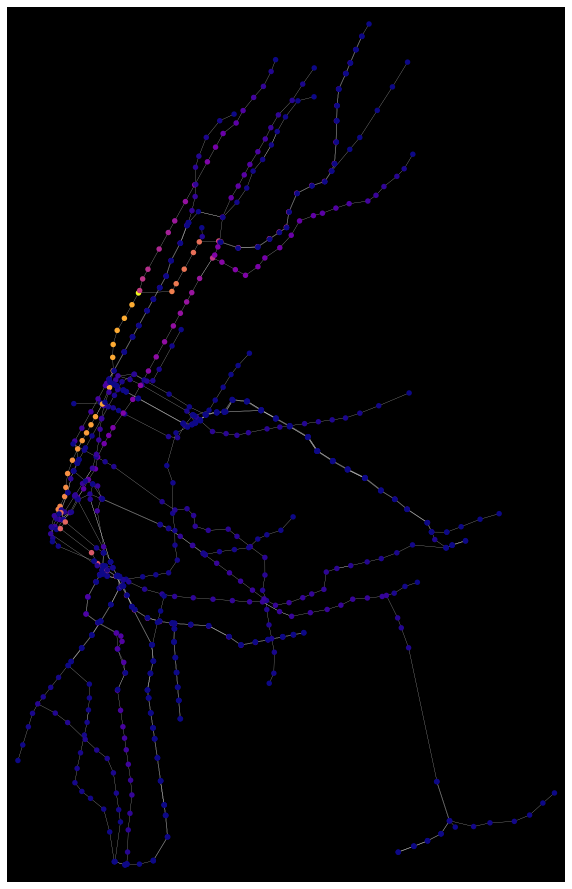

In [148]:
bc = nx.betweenness_centrality(H)
len(bc)

nx.set_node_attributes(G_u, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G_u, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G_u,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
    figsize=(10, 20)
)

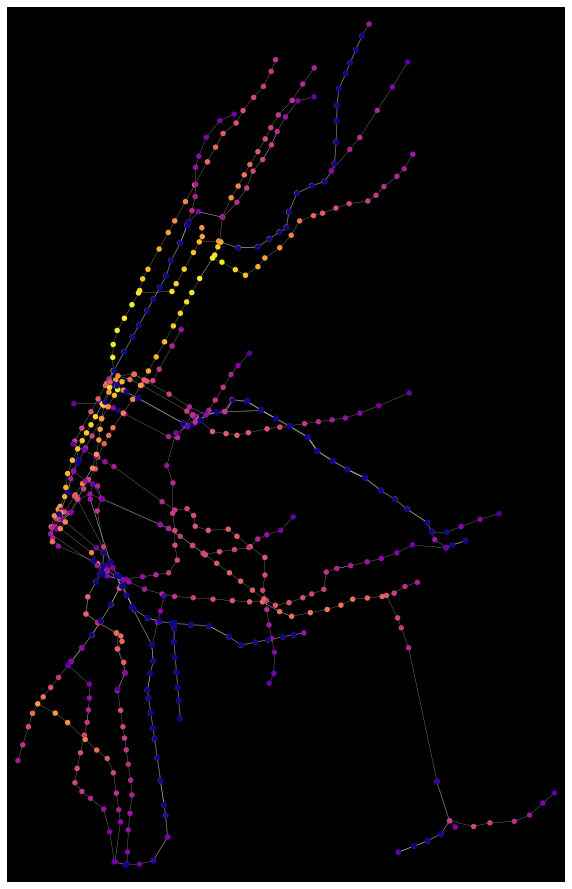

In [150]:
cc = nx.closeness_centrality(H)
len(cc)

nx.set_node_attributes(G_u, cc, "cc")
nc = ox.plot.get_node_colors_by_attr(G_u, "cc", cmap="plasma")
fig, ax = ox.plot_graph(
    G_u,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
    figsize=(10, 20)
)

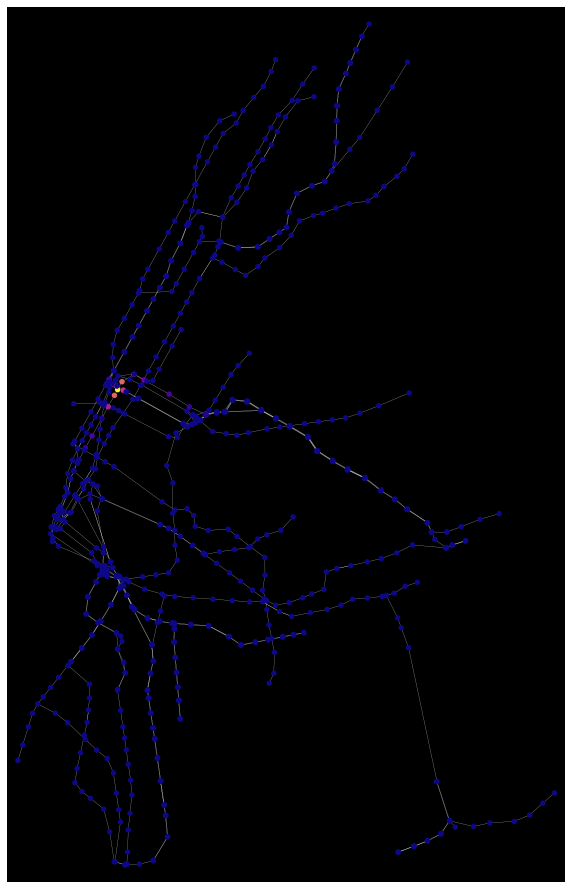

In [156]:
ec = nx.eigenvector_centrality(H, max_iter=500)
len(ec)

nx.set_node_attributes(G_u, ec, "ec")
nc = ox.plot.get_node_colors_by_attr(G_u, "ec", cmap="plasma")
fig, ax = ox.plot_graph(
    G_u,
    node_color=nc,
    node_size=30,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
    bgcolor="k",
    figsize=(10, 20)
)

# https://tyleragreen.com/blog/2017/03/graphing-transit-systems-part-ii-centrality/

In [ ]:
https://tyleragreen.com/blog/2017/03/graphing-transit-systems-part-ii-centrality/

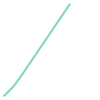

In [133]:
gdf.iloc[0].geometry

In [120]:
G

In [121]:
gdf

,id,name,objectid,rt_symbol,shape_len,url,geometry,End_pos,Start_pos,TNODE_,FNODE_
0,2000393.0,G,753.0,G,2438.200249,http://web.mta.info/nyct/service/,"LINESTRING (-73.99488 40.68020, -73.99427 40.6...","(-73.99487524803018, 40.6802035460625)","(-73.99066967148987, 40.68606925530288)",0,742
1,2000394.0,G,754.0,G,3872.834411,http://web.mta.info/nyct/service/,"LINESTRING (-73.97958 40.65993, -73.97966 40.6...","(-73.97957543205142, 40.65993069553076)","(-73.9756594994904, 40.65072922971845)",1,516
2,2000469.0,Q,755.0,N,1843.366331,http://web.mta.info/nyct/service/,"LINESTRING (-73.97586 40.57597, -73.97654 40.5...","(-73.97585637503069, 40.5759745053941)","(-73.9811502261517, 40.57728494923349)",2,744
3,2000294.0,M,756.0,B,1919.559203,http://web.mta.info/nyct/service/,"LINESTRING (-73.92414 40.75229, -73.92405 40.7...","(-73.92414355434533, 40.752290926571746)","(-73.92055564103553, 40.75679224872182)",3,745
4,2000294.0,M,895.0,B,1919.559203,http://web.mta.info/nyct/service/,"LINESTRING (-73.92414 40.75229, -73.92405 40.7...","(-73.92414355434533, 40.752290926571746)","(-73.92055564103553, 40.75679224872182)",3,745
...,...,...,...,...,...,...,...,...,...,...,...
737,2000004.0,1,1488.0,1,1071.618101,http://web.mta.info/nyct/service/,"LINESTRING (-74.01219 40.71183, -74.01211 40.7...","(-74.012188001062, 40.711834667631244)","(-74.01018799986436, 40.71430266706666)",735,592
738,2000075.0,2-3,1489.0,1,695.727411,http://web.mta.info/nyct/service/,"LINESTRING (-74.00881 40.71305, -74.01003 40.7...","(-74.00881099992978, 40.71305066768981)","(-74.01018799986436, 40.71430266706666)",736,592
739,0.0,Q,1718.0,N,3779.620046,http://web.mta.info/nyct/service/,"LINESTRING (-73.95836 40.76880, -73.95787 40.7...","(-73.95836178682246, 40.76880251014895)","(-73.95174238196597, 40.777874305694084)",738,720
740,0.0,N-W,1809.0,N,2194.718931,http://web.mta.info/nyct/service/,"LINESTRING (-73.94014 40.75069, -73.93989 40.7...","(-73.94013575501214, 40.75069452697714)","(-73.93275500071513, 40.75288166664559)",740,189
